# This task is to predict company's increase in profitability compared to the previous year

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc1").config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven").getOrCreate()
spark

read data from s3

In [2]:
df = spark.read.parquet("s3://502-project-1/data")

drop null values in columns "operatingIncomeLoss" and "profit", as these two columns will be used as labels
<br>
replace null with zero in other columns
<br>
add a new column "profit_increase" represents difference between this year's profit and last year's profit

In [3]:
df = df.na.drop(subset=['OperatingIncomeLoss', 'profit'])
df = df.na.fill(0)
df = df.withColumn('profit_increase', df.profit - df.OperatingIncomeLoss)

create label column which depends on the profit_increase column

In [4]:
df.createOrReplaceTempView("dfTable")
df = spark.sql("select *, CASE \
                   when profit_increase > 0 then 1 \
                   when profit_increase <= 0 then 0 \
                   end as label from dfTable")

columns and numeric columns

In [7]:
cols = ['cik', 'company_name', 'assigned_sic', 'accession_number_int', 'filing_date', 
        'CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
        'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
        'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
        'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 'LaborAndRelatedExpense', 
        'NetCashProvidedByUsedInFinancingActivities', 
        'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInInvestingActivities', 
        'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInOperatingActivities', 
        'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 'NetIncomeLoss', 'OperatingExpenses', 
        'PaymentsForRepurchaseOfCommonStock', 'PaymentsOfDividends', 
        'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 
        'PaymentsToAcquireBusinessesNetOfCashAcquired', 'PaymentsToAcquirePropertyPlantAndEquipment', 
        'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 'Revenues', 'SellingAndMarketingExpense', 
        'ShareBasedCompensation', 'year', 'profit_year', 'profit', 'profit_increase', 'label']

numericCols = ['CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses', 'PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']

using vectorassembler and pipline to create "features" columns

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
assembler = VectorAssembler(inputCols=numericCols, outputCol="features", handleInvalid="keep")
pipeline = Pipeline(stages=[assembler])
pipelineModel = pipeline.fit(df)

In [14]:
df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- cik: integer (nullable = true)
 |-- company_name: string (nullable = true)
 |-- assigned_sic: integer (nullable = true)
 |-- accession_number_int: long (nullable = true)
 |-- filing_date: date (nullable = true)
 |-- CostOfGoodsAndServicesSold: double (nullable = false)
 |-- CostOfGoodsSold: double (nullable = false)
 |-- CostOfServices: double (nullable = false)
 |-- EarningsPerShareBasic: double (nullable = false)
 |-- EarningsPerShareDiluted: double (nullable = false)
 |-- GainLossOnDispositionOfAssets: double (nullable = false)
 |-- GeneralAndAdministrativeExpense: double (nullable = false)
 |-- IncomeTaxesPaid: double (nullable = false)
 |-- IncreaseDecreaseInAccountsPayable: double (nullable = false)
 |-- IncreaseDecreaseInAccountsReceivable: double (nullable = false)
 |-- IncreaseDecreaseInAccruedLiabilities: double (nullable = false)
 |-- IncreaseDecreaseInInventories: double (nullable = false)
 |-- LaborAndRelatedExpense: double

Given the outstanding performance of lightGBM model in task 1, we use lightGBM model first

## Regression using lightGBM model 

In [10]:
import mmlspark
from mmlspark.lightgbm import LightGBMRegressor

train, test = df.randomSplit([0.85, 0.15], seed=1)
lgb = LightGBMRegressor(alpha=0.3, learningRate=0.3, numIterations=100, numLeaves=31, featuresCol='features',labelCol='profit_increase')
lgbModel = lgb.fit(train)
test_model = lgbModel.transform(test)

the result is not satisfying, further jobs need to be done.
<br>
try feature engineering first

In [12]:
from mmlspark.train import ComputeModelStatistics
metrics = ComputeModelStatistics(evaluationMetric='regression',
                                 labelCol='profit_increase',
                                 scoresCol='prediction') \
            .transform(test_model)
metrics.toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
0,1.476673e+19,3.842750e+09,-0.230962,2.685616e+08


## Feature Engineering

See feature importance

In [17]:
feature_importance = lgbModel.getFeatureImportances()
print(feature_importance)

[66.0, 35.0, 16.0, 108.0, 36.0, 23.0, 53.0, 31.0, 166.0, 138.0, 54.0, 142.0, 16.0, 183.0, 28.0, 138.0, 81.0, 165.0, 83.0, 172.0, 18.0, 204.0, 138.0, 36.0, 149.0, 6.0, 172.0, 161.0, 90.0, 37.0, 138.0, 25.0, 92.0]


sort features according to their importance from high to low

In [5]:
feature_importance = [99.0, 36.0, 12.0, 196.0, 81.0, 4.0, 58.0, 22.0, 156.0, 134.0, 17.0, 138.0, 8.0, 254.0, 35.0, 129.0, 67.0, 191.0, 38.0, 191.0, 22.0, 177.0, 127.0, 23.0, 104.0, 5.0, 209.0, 149.0, 94.0, 17.0, 101.0, 0.0, 106.0]

In [8]:
sorted_feature = [x for _,x in sorted(zip(feature_importance, numericCols), reverse=True)]

select top 15 most important features

In [9]:
selected_features = sorted_feature[:15]
print(selected_features)

['NetCashProvidedByUsedInFinancingActivities', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 'EarningsPerShareBasic', 'NetIncomeLoss', 'NetCashProvidedByUsedInOperatingActivities', 'OperatingIncomeLoss', 'IncreaseDecreaseInAccountsPayable', 'PaymentsToAcquirePropertyPlantAndEquipment', 'IncreaseDecreaseInInventories', 'IncreaseDecreaseInAccountsReceivable', 'NetCashProvidedByUsedInInvestingActivities', 'PaymentsForRepurchaseOfCommonStock', 'ShareBasedCompensation', 'PaymentsOfDividendsCommonStock', 'Revenues']


update new columns and numeric columns

In [10]:
cols = ['cik', 'company_name', 'assigned_sic', 'accession_number_int', 'filing_date', 
        'CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
        'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
        'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
        'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 'LaborAndRelatedExpense', 
        'NetCashProvidedByUsedInFinancingActivities', 
        'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInInvestingActivities', 
        'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInOperatingActivities', 
        'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 'NetIncomeLoss', 'OperatingExpenses', 
        'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 'PaymentsOfDividends', 
        'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 
        'PaymentsToAcquireBusinessesNetOfCashAcquired', 'PaymentsToAcquirePropertyPlantAndEquipment', 
        'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 'Revenues', 'SellingAndMarketingExpense', 
        'ShareBasedCompensation', 'year', 'profit_year', 'profit', 'profit_increase', 'label']

numericCols = ['CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses', 'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']

drop previously created features column first

In [15]:
df = df.drop(df.features)

In [16]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="features", handleInvalid="keep")
pipeline = Pipeline(stages=[assembler])
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- cik: integer (nullable = true)
 |-- company_name: string (nullable = true)
 |-- assigned_sic: integer (nullable = true)
 |-- accession_number_int: long (nullable = true)
 |-- filing_date: date (nullable = true)
 |-- CostOfGoodsAndServicesSold: double (nullable = false)
 |-- CostOfGoodsSold: double (nullable = false)
 |-- CostOfServices: double (nullable = false)
 |-- EarningsPerShareBasic: double (nullable = false)
 |-- EarningsPerShareDiluted: double (nullable = false)
 |-- GainLossOnDispositionOfAssets: double (nullable = false)
 |-- GeneralAndAdministrativeExpense: double (nullable = false)
 |-- IncomeTaxesPaid: double (nullable = false)
 |-- IncreaseDecreaseInAccountsPayable: double (nullable = false)
 |-- IncreaseDecreaseInAccountsReceivable: double (nullable = false)
 |-- IncreaseDecreaseInAccruedLiabilities: double (nullable = false)
 |-- IncreaseDecreaseInInventories: double (nullable = false)
 |-- LaborAndRelatedExpense: double

redo the regression job

In [21]:
lgb = LightGBMRegressor(alpha=0.3, learningRate=0.3, numIterations=100, numLeaves=31, featuresCol='features',labelCol='profit_increase')
lgbModel = lgb.fit(train)
test_model = lgbModel.transform(test)

we can see slight improvement after feature engineering

In [22]:
from mmlspark.train import ComputeModelStatistics
metrics = ComputeModelStatistics(evaluationMetric='regression',
                                 labelCol='profit_increase',
                                 scoresCol='prediction') \
            .transform(test_model)
metrics.toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
0,5.322156e+18,2.306980e+09,-0.043436,2.336532e+08


## Now we will do the classification job
### LightGBM Classifier

In [23]:
from mmlspark.lightgbm import LightGBMClassifier
lgbClassifier = LightGBMClassifier(learningRate=0.3,
                           numIterations=100,
                           numLeaves=31,
                           featuresCol = 'features',
                            labelCol = 'label')

In [24]:
lgbClassifierModel = lgbClassifier.fit(train)
test_class = lgbClassifierModel.transform(test)

get AUC value

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as bce
evaluator = bce(rawPredictionCol='probability', labelCol='profit')
print(evaluator.evaluate(test_class, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_class, {evaluator.metricName: 'areaUnderPR'}))

0.5478801056749568
0.5860782591293228


output predicted value and confusion matrix

In [27]:
y_true = test_class.select(['label']).collect()
y_pred = test_class.select(['prediction']).collect()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49      1089
           1       0.62      0.64      0.63      1443

    accuracy                           0.57      2532
   macro avg       0.56      0.56      0.56      2532
weighted avg       0.57      0.57      0.57      2532



In [29]:
confusion_matrix(y_true, y_pred, labels=[0, 1])

array([[524, 565],
       [517, 926]])

### logistic regression model

In [30]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

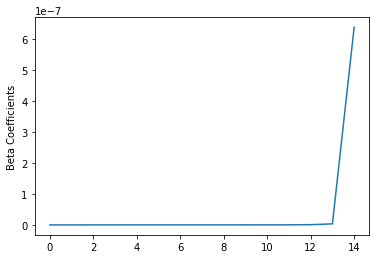

In [31]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

output AUC, F1 and Confusion Matrix

In [32]:
predictions = lrModel.transform(test)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5433532706259978


In [33]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred, labels=[0, 1])

              precision    recall  f1-score   support

           0       0.39      0.01      0.02      1089
           1       0.57      0.99      0.72      1443

    accuracy                           0.57      2532
   macro avg       0.48      0.50      0.37      2532
weighted avg       0.49      0.57      0.42      2532



array([[  12, 1077],
       [  19, 1424]])

#### We can see LightGBM Classifier again outperforms Logistic Regression Model.